In [1]:
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

In [5]:
from torchvision import datasets as Datasets
from torchvision import transforms

cifar10_train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


cifar10_test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

#  loading training data
training_set = Datasets.CIFAR10(root='../../autoencoder', download=False, train=True, transform=cifar10_train_transforms)

#  loading validation data
validation_set = Datasets.CIFAR10(root='../../autoencoder', download=False, train=False, transform=cifar10_test_transforms)

# Dict for label to class
l2c = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

In [34]:
# Create data loaders
batch_size = 512
train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=16)
val_loader_shuffle = DataLoader(validation_set, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=16)

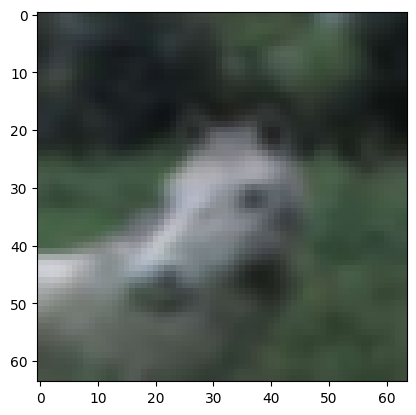

In [7]:
# Show image
img, label = next(iter(train_loader))
plt.imshow(img[0].permute(1, 2, 0)*.5+.5)

In [8]:
def xavier_init(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.ConvTranspose2d):
            nn.init.xavier_normal_(m.weight)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)

In [11]:
def conv_block(in_channels, out_channels, kernel_size, stride, padding, batch_norm=True, act=None):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm)),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True) if act == None else act,
    )

def convT_block(in_channels, out_channels, kernel_size, stride, padding, batch_norm=True, act=None):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=(not batch_norm)),
        nn.BatchNorm2d(out_channels) if batch_norm else nn.Identity(),
        nn.LeakyReLU(0.2, inplace=True) if act == None else act,
    )

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super().__init__()
        self.conv1 = nn.Sequential(
            conv_block(in_channels, out_channels, kernel_size, stride, padding),
            conv_block(out_channels, out_channels, kernel_size, stride, padding, act=nn.Identity()),
        )
        self.conv2 = conv_block(in_channels, out_channels, 1, 1, 0, act=nn.Identity())

    def forward(self, x):
        out = self.conv1(x)
        out += self.conv2(x)
        return F.relu(out)

class VQVAE(nn.Module):
    def __init__(self, K=512, D=128, beta=0.2):
        super().__init__()
        self.K = K
        self.D = D
        self.beta = beta

        self.encoder = nn.Sequential(
            conv_block(3, 32, 4, 2, 1),
            conv_block(32, 64, 4, 2, 1),
            conv_block(64, 128, 4, 2, 1),
            ResidualBlock(128, 256, 3, 1, 1),
            ResidualBlock(256, self.D, 3, 1, 1),
        )
        self.embedding = nn.Embedding(self.K, self.D)
        self.decoder = nn.Sequential(
            convT_block(self.D, 128, 4, 2, 1),
            convT_block(128, 64, 4, 2, 1),
            convT_block(64, 32, 4, 2, 1),
            convT_block(32, 16, 3, 1, 1),
            convT_block(16, 3, 3, 1, 1, batch_norm=False, act=nn.Tanh()),
        )

    def forward(self, x):
        z = self.encoder(x)
        B, C, H, W = z.size()
        z = z.permute(0, 2, 3, 1).contiguous().view(-1, self.D)
        z_q = self.quantize(z)

        # Codebook loss + commitment loss
        loss_vq = torch.mean((z_q - z.detach())**2) + self.beta * torch.mean((z - z_q.detach())**2)

        # Straight through estimation of gradients (Gradients of z_q will go to z)
        z_q = z + (z_q - z).detach()
        z_q = z_q.view(B, H, W, self.D).permute(0, 3, 1, 2)
        z_q = self.decoder(z_q)

        return z_q, loss_vq
    
    def quantize(self, z):
        # Find pairwise distances between z and embedding vectors (This is square of the L2 norm)
        dist_sq = torch.sum(z**2, dim=1, keepdim=True) + torch.sum(self.embedding.weight**2, dim=1).view(-1, self.embedding.weight.size(0)) - 2 * z @ self.embedding.weight.T  # (B, K)
        min_idx = torch.argmin(dist_sq, dim=-1)         # (B*H*W,)
        z_q = self.embedding(min_idx)                   # (B*H*W, D)
        return z_q

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE(K=1024, D=64, beta=0.2).to(device)
xavier_init(model)

In [21]:
optimizer = optim.Adam(model.parameters(), lr=2e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

In [32]:
epochs = 10
for epoch in range(epochs):
    model.train()
    tqdm_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}')
    for img, _ in tqdm_loader:
        img = img.to(device)
        optimizer.zero_grad()

        # Forward pass
        img_recon, loss_vq = model(img)
        loss_recon = F.mse_loss(img_recon, img)
        loss = loss_recon + loss_vq

        loss.backward()
        optimizer.step()
        scheduler.step()

        tqdm.set_description(tqdm_loader, f'Loss: {loss.item():.4f}, Recon Loss: {loss_recon.item():.4f}, VQ Loss: {loss_vq.item():.4f}')

Loss: 0.2550, Recon Loss: 0.0365, VQ Loss: 0.2185: 100%|██████████| 98/98 [00:12<00:00,  8.00it/s]
Loss: 0.2393, Recon Loss: 0.0353, VQ Loss: 0.2040: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s]
Loss: 0.2429, Recon Loss: 0.0352, VQ Loss: 0.2077: 100%|██████████| 98/98 [00:12<00:00,  7.99it/s]
Loss: 0.2636, Recon Loss: 0.0368, VQ Loss: 0.2268: 100%|██████████| 98/98 [00:12<00:00,  8.01it/s]
Loss: 0.2429, Recon Loss: 0.0351, VQ Loss: 0.2078: 100%|██████████| 98/98 [00:12<00:00,  8.00it/s]
Loss: 0.2606, Recon Loss: 0.0343, VQ Loss: 0.2263: 100%|██████████| 98/98 [00:12<00:00,  7.90it/s]
Loss: 0.2632, Recon Loss: 0.0336, VQ Loss: 0.2296: 100%|██████████| 98/98 [00:12<00:00,  7.96it/s]
Loss: 0.2584, Recon Loss: 0.0328, VQ Loss: 0.2256: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]
Loss: 0.2544, Recon Loss: 0.0322, VQ Loss: 0.2222: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s]
Loss: 0.2612, Recon Loss: 0.0326, VQ Loss: 0.2286: 100%|██████████| 98/98 [00:12<00:00,  8.01it/s]


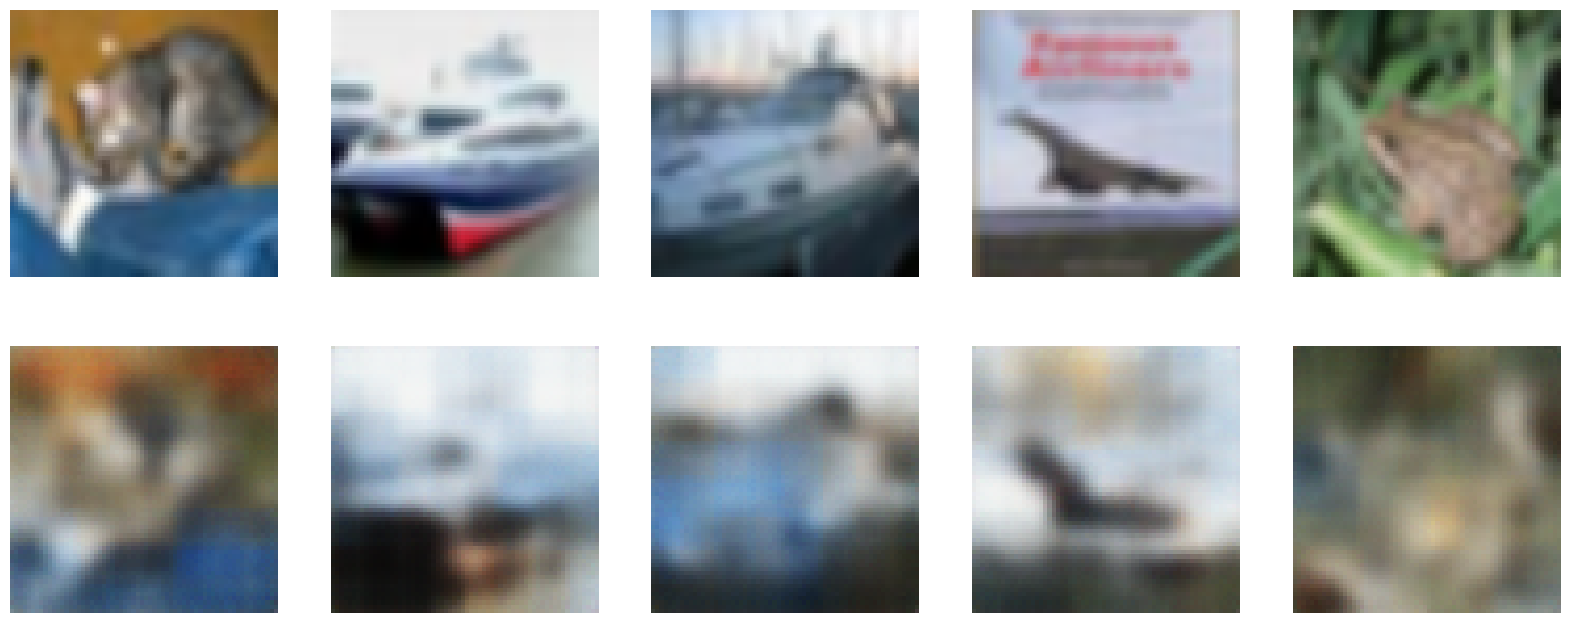

In [33]:
def show_reconstructions(model, loader):
    model.eval()
    img, _ = next(iter(loader))
    img = img.to(device)
    recon, _ = model(img)
    img = img.cpu()
    recon = recon.detach().cpu()

    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(5):
        axes[0, i].imshow(img[i].permute(1, 2, 0)*.5+.5)
        axes[1, i].imshow(recon[i].permute(1, 2, 0)*.5+.5)
        axes[0, i].axis('off')
        axes[1, i].axis('off')
show_reconstructions(model, val_loader)

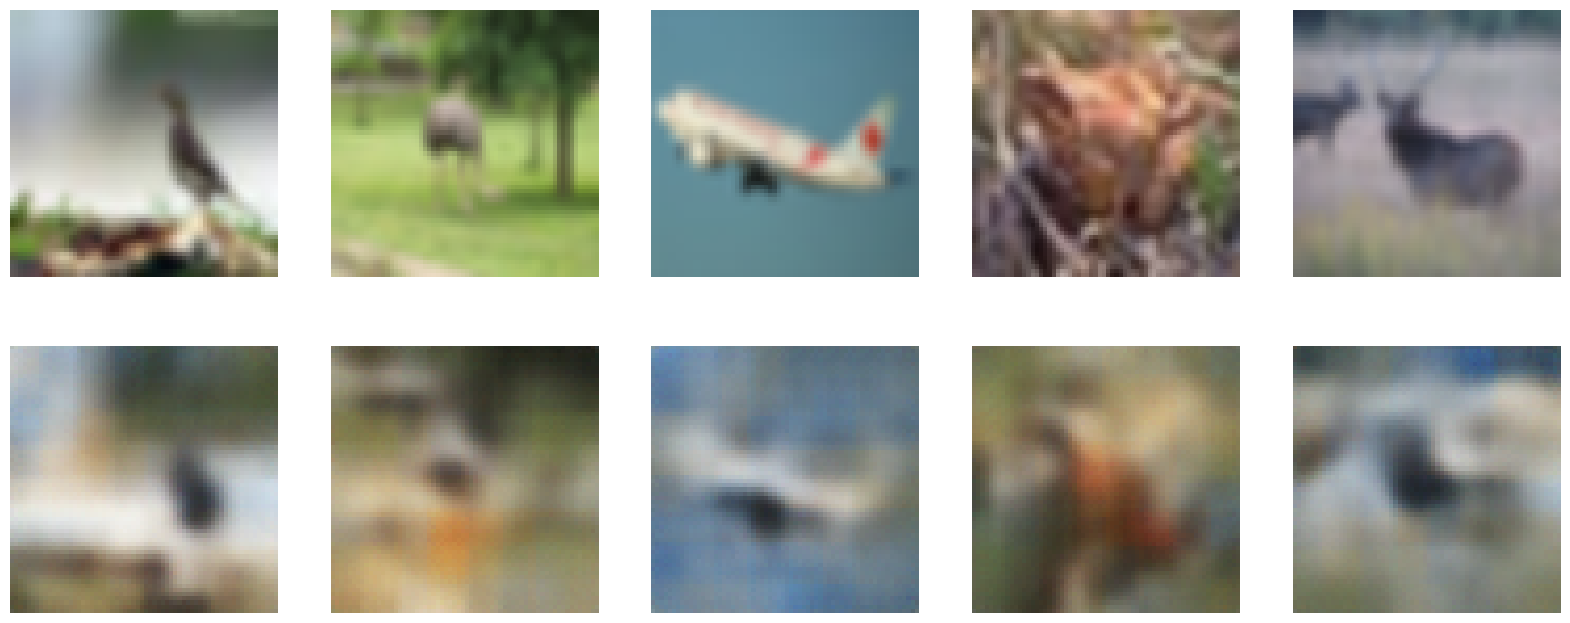

In [36]:
show_reconstructions(model, val_loader_shuffle)